# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
try:
    # one of the ways to check if our notebook is running inside google colab
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/gmum/ml2025-26.git
    import sys
    sys.path.append('/content/ml2025-26/lab')

Cloning into 'ml2025-26'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 114 (delta 38), reused 107 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (114/114), 12.71 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

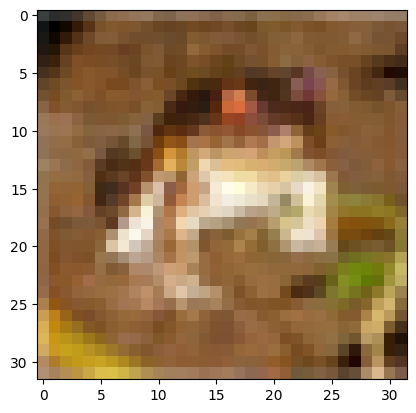

In [3]:
# data loading
if IN_COLAB:
    cifar_sample = np.load("/content/ml2025-26/lab/resources/cifar_sample.npy")
else:
    cifar_sample = np.load("resources/cifar_sample.npy")

# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = K $  

$ \hspace{140px} H_o =  \frac{H_i - F + 2P}{S} + 1  $

$ \hspace{140px} W_o = \frac{W_i - F + 2P}{S} + 1 $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   

$ ( F \times F \times C_f + 1 ) \times K $

### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

![cnn.gif](https://raw.githubusercontent.com/gmum/ml2025-26/main/lab/resources/cnn.gif)

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli).

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [4]:
def convolution(image: torch.tensor,
                filters: torch.tensor,
                bias: torch.tensor,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param filters: torch.Tensor
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    n_filters, filter_channels, filter_size, filter_size = filters.shape
    # calculate the dimensions of the output image
    out_height = int((img_height - filter_size + 2 * padding) / stride) + 1
    out_width = int((img_width - filter_size + 2 * padding) / stride) + 1
    out_channels = n_filters
    conv_out = torch.empty((out_channels, out_height, out_width))
    padded_image = torch.tensor(np.pad(
    image,
    pad_width=((0, 0), (padding, padding), (padding, padding)),
    mode='constant',
    constant_values=0))

    for i_h in range(out_height):
      for i_w in range(out_width):
        h_start = stride * i_h
        w_start = stride * i_w
        fragment = padded_image[:, h_start:h_start+filter_size, w_start:w_start+filter_size]
        for n, filter in enumerate(filters):
          conv_element = torch.sum(fragment * filter)
          conv_out[n, i_h, i_w] = conv_element
        conv_out[:, i_h, i_w] = conv_out[:, i_h, i_w] + bias

    return conv_out

In [5]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [6]:
def max_pooling(image: torch.tensor,
                kernel_size: int,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param kernel_size: int
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # your code here
    out_height = int((img_height - kernel_size + 2 * padding) / stride) + 1
    out_width = int((img_width - kernel_size + 2 * padding) / stride) + 1
    out_channels = img_channels
    conv_out = torch.empty((out_channels, out_height, out_width))
    padded_image = torch.tensor(np.pad(
    image,
    pad_width=((0, 0), (padding, padding), (padding, padding)),
    mode='constant',
    constant_values=0))

    for i_h in range(out_height):
      for i_w in range(out_width):
        h_start = stride * i_h
        w_start = stride * i_w
        fragment = padded_image[:, h_start:h_start+kernel_size, w_start:w_start+kernel_size]
        conv_out[:, i_h, i_w] = torch.max(fragment.reshape(fragment.size(0), -1), dim=1).values

    return conv_out

In [7]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [46]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

100%|██████████| 170M/170M [00:03<00:00, 46.2MB/s]


CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


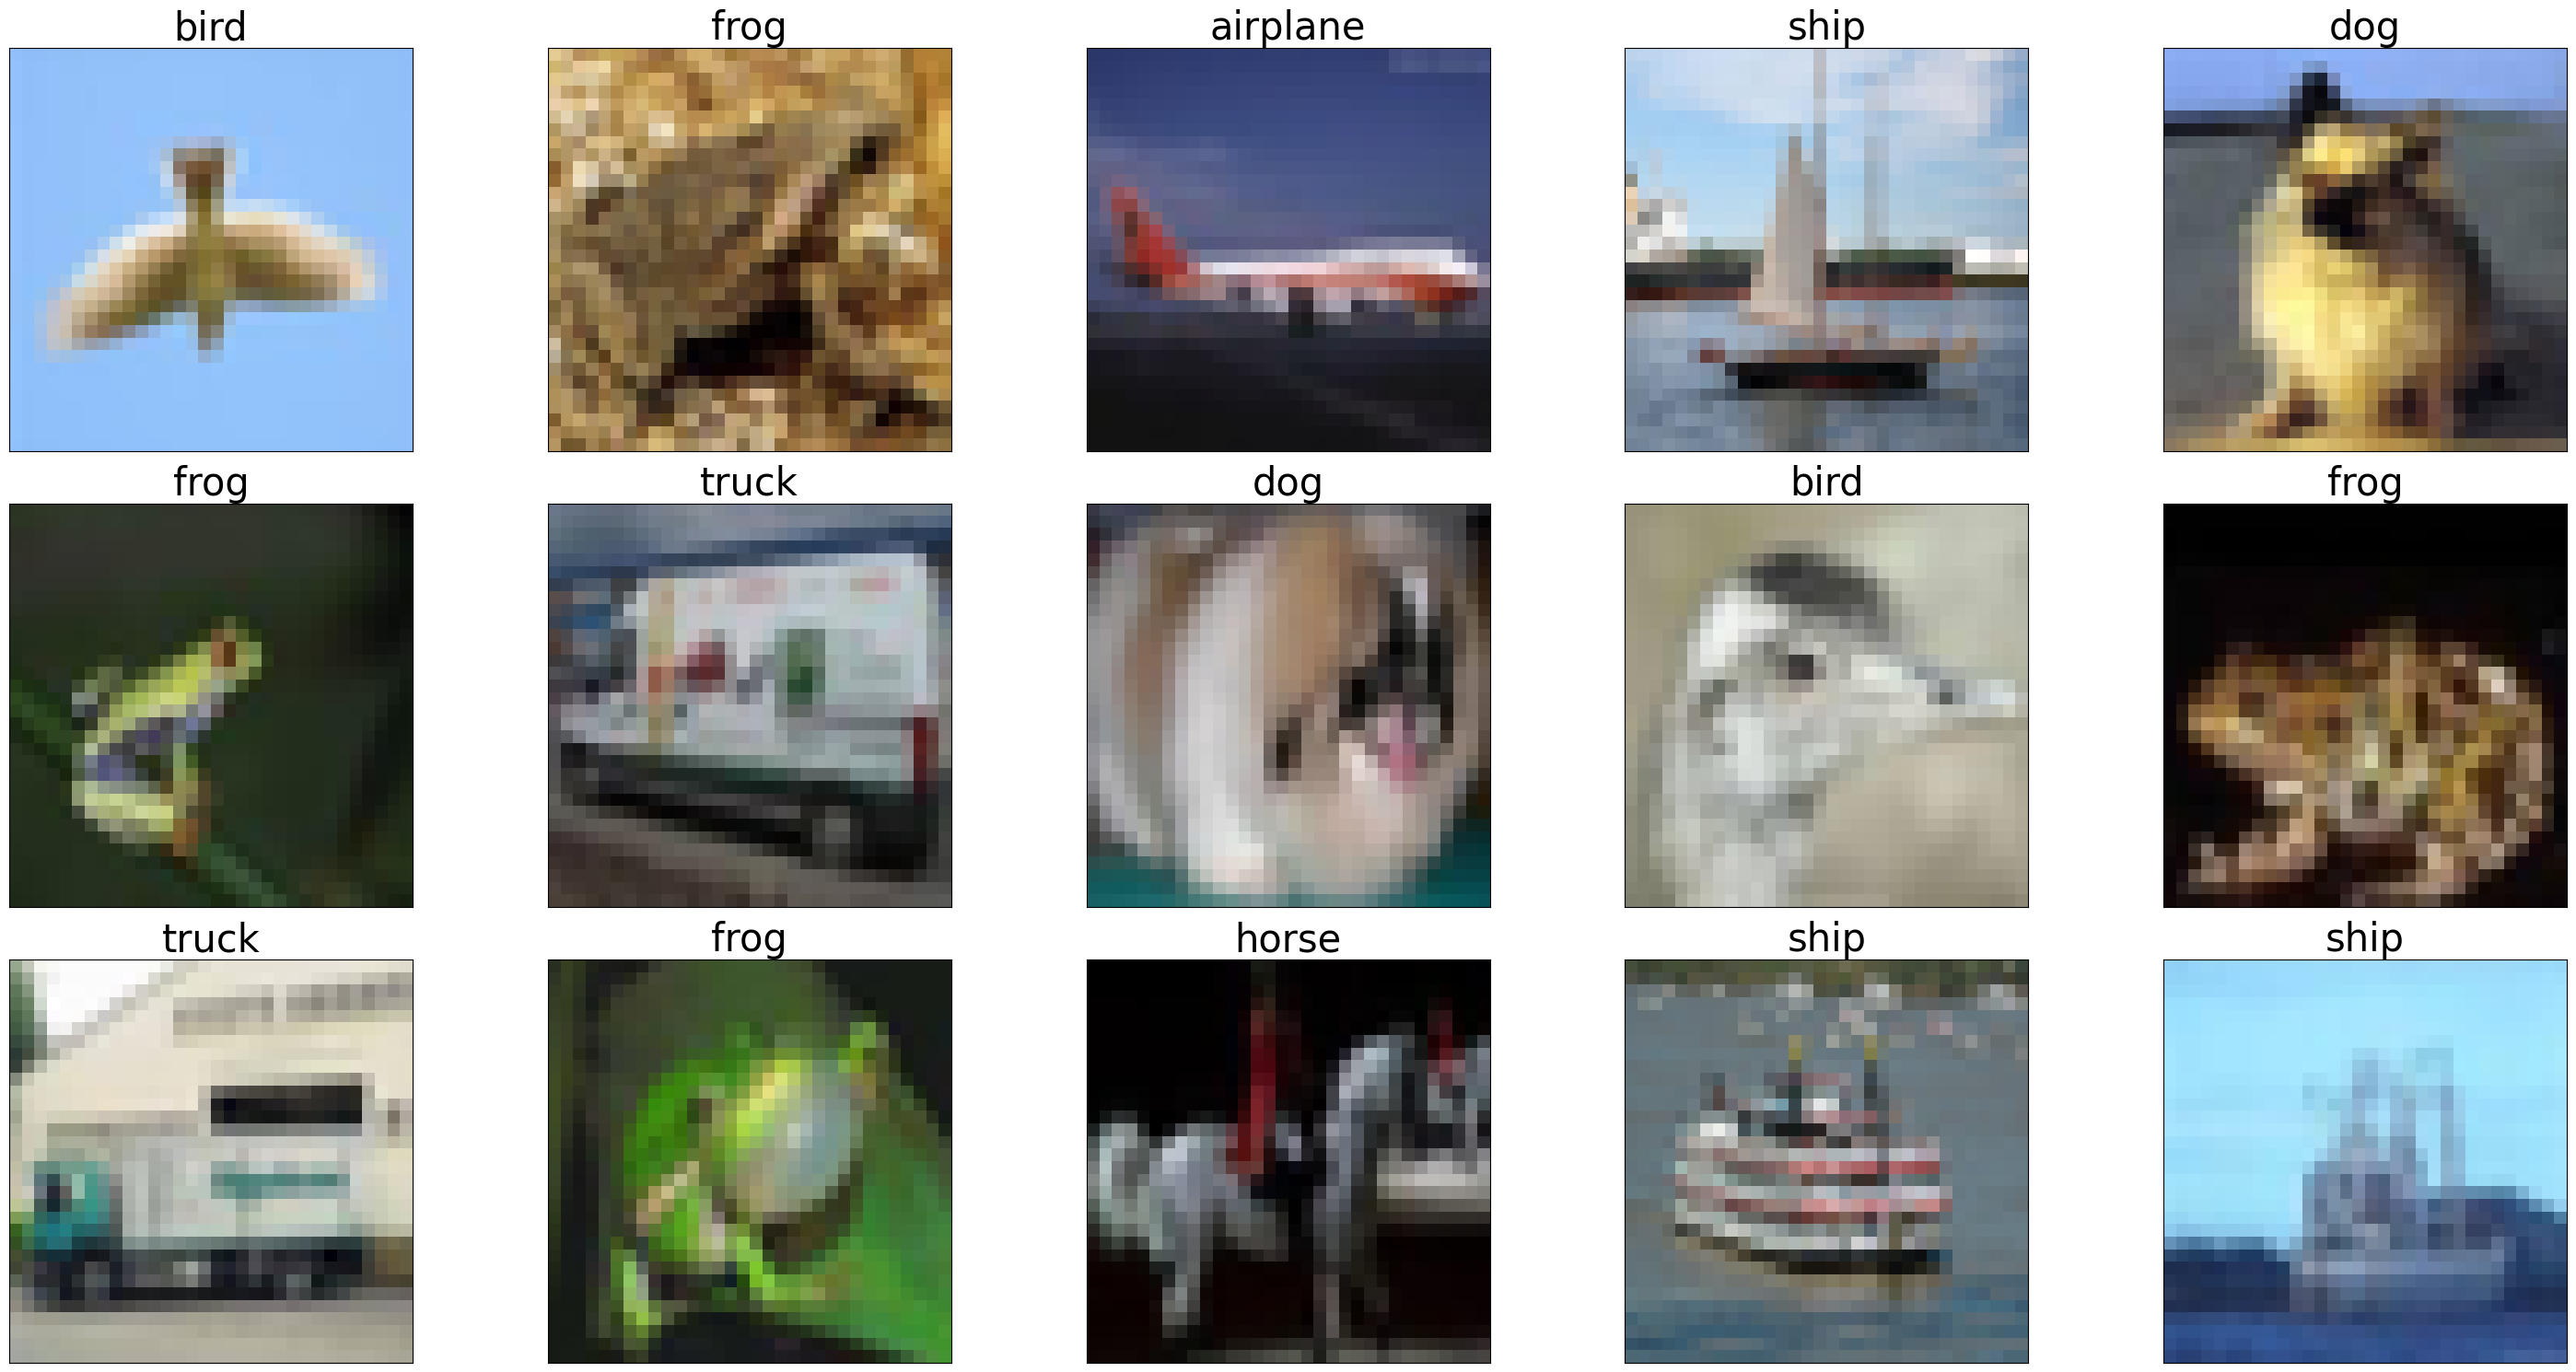

In [7]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [16]:
from torch import nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super(ConvNet, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels=256, kernel_size=3, padding=2)
        self.bn_1 = nn.BatchNorm2d(num_features=256)
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3)
        self.bn_2 = nn.BatchNorm2d(num_features=128)
        self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        self.bn_3 = nn.BatchNorm2d(num_features=128)
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc_1 = nn.Linear(in_features=512, out_features=10)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = F.relu(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = F.relu(x)
        x = self.pool_3(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_1(x)
        return x


In [48]:
# tutaj uzupełnij ładowanie danych treningowych i testowych
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.4914, 0.4822, 0.4465),
                 (0.247, 0.243, 0.261))
])

train_dataset_full = CIFAR10(root='.',
                             train=True,
                             download=True,
                             transform=transforms)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=transforms)

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False)

In [49]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0

    def __call__(self, val_acc, model):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        print(f'Accuracy increased. ({self.val_acc_max:.6f} → {val_acc:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc


In [51]:
from collections.abc import Callable
from tqdm import tqdm


def evaluate(model, test_loader, loss_fn, device):
    correct, numel = 0, 0
    model.eval()
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            output = model(x_test)
            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y_test).item()
            numel += x_test.shape[0]
        loss = loss_fn(output, y_test)
        train_loss = loss.item()
        epoch_acc = correct / numel
    return train_loss, epoch_acc


def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    train_loader: DataLoader,
    val_loader: DataLoader,
    patience: int,
    delta: float,
    loss_fn: Callable = torch.nn.functional.cross_entropy,
    n_epochs: int = 100,
) -> dict[str, list[float]]:
    logs = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
    }
    device = "cuda" if torch.cuda.is_available() else "cpu"
    early_stopping = EarlyStopping(patience=patience, delta=delta)

    print(f"Device: {device}")
    model = model.to(device)
    correct, numel = 0, 0
    for e in range(1, n_epochs + 1):
        print(f"EPOCH {e}")
        model.train()
        for x, y in tqdm(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            y_pred = torch.argmax(output, dim=1)
            correct += torch.sum(y_pred == y).item()
            numel += x.shape[0]
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
        scheduler.step()
        train_loss, epoch_acc = evaluate(model, val_loader, loss_fn, device)

        logs["train_loss"].append(train_loss)
        logs["train_accuracy"].append(epoch_acc)
        print(f"Training loss: {train_loss}, Training accuracy: {epoch_acc}")

        test_loss = loss.item()
        test_acc = correct / numel
        logs["val_loss"].append(test_loss)
        logs["val_accuracy"].append(test_acc)
        print(f"Val loss: {test_loss}, Val accuracy: {test_acc}")

        early_stopping(test_acc, model)

        if early_stopping.early_stop:
          print("Early stopping triggered!")
          break

    return logs

In [52]:
model = ConvNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 5
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 704/704 [00:17<00:00, 40.31it/s]


Training loss: 1.3013532161712646, Training accuracy: 0.62
Val loss: 0.6020875573158264, Val accuracy: 0.5267777777777778
Accuracy increased. (0.000000 → 0.526778). Saving model...
EPOCH 2


100%|██████████| 704/704 [00:16<00:00, 42.53it/s]


Training loss: 0.5698602199554443, Training accuracy: 0.6778
Val loss: 0.5293506979942322, Val accuracy: 0.6029555555555556
Accuracy increased. (0.526778 → 0.602956). Saving model...
EPOCH 3


100%|██████████| 704/704 [00:17<00:00, 40.37it/s]


Training loss: 0.8066999912261963, Training accuracy: 0.7278
Val loss: 0.8756173849105835, Val accuracy: 0.6490074074074074
Accuracy increased. (0.602956 → 0.649007). Saving model...
EPOCH 4


100%|██████████| 704/704 [00:17<00:00, 41.07it/s]


Training loss: 0.19971711933612823, Training accuracy: 0.7342
Val loss: 0.2748308479785919, Val accuracy: 0.6830055555555555
Accuracy increased. (0.649007 → 0.683006). Saving model...
EPOCH 5


100%|██████████| 704/704 [00:16<00:00, 43.05it/s]


Training loss: 0.3194432258605957, Training accuracy: 0.748
Val loss: 1.1483190059661865, Val accuracy: 0.7110488888888888
Accuracy increased. (0.683006 → 0.711049). Saving model...
EPOCH 6


100%|██████████| 704/704 [00:16<00:00, 42.04it/s]


Training loss: 0.42281603813171387, Training accuracy: 0.7382
Val loss: 0.20278190076351166, Val accuracy: 0.7350777777777778
Accuracy increased. (0.711049 → 0.735078). Saving model...
EPOCH 7


100%|██████████| 704/704 [00:17<00:00, 40.69it/s]


Training loss: 0.13374032080173492, Training accuracy: 0.7494
Val loss: 0.2826266586780548, Val accuracy: 0.7573492063492063
Accuracy increased. (0.735078 → 0.757349). Saving model...
EPOCH 8


100%|██████████| 704/704 [00:17<00:00, 41.30it/s]


Training loss: 0.05071479454636574, Training accuracy: 0.7468
Val loss: 0.30561116337776184, Val accuracy: 0.7776666666666666
Accuracy increased. (0.757349 → 0.777667). Saving model...
EPOCH 9


100%|██████████| 704/704 [00:16<00:00, 42.60it/s]


Training loss: 0.34256041049957275, Training accuracy: 0.7472
Val loss: 0.038419660180807114, Val accuracy: 0.7956543209876543
Accuracy increased. (0.777667 → 0.795654). Saving model...
EPOCH 10


100%|██████████| 704/704 [00:16<00:00, 41.84it/s]


Training loss: 0.30574163794517517, Training accuracy: 0.7396
Val loss: 0.3731440603733063, Val accuracy: 0.8121044444444444
Accuracy increased. (0.795654 → 0.812104). Saving model...
EPOCH 11


100%|██████████| 704/704 [00:16<00:00, 43.07it/s]


Training loss: 0.1054285317659378, Training accuracy: 0.755
Val loss: 0.26089194416999817, Val accuracy: 0.8264727272727272
Accuracy increased. (0.812104 → 0.826473). Saving model...
EPOCH 12


100%|██████████| 704/704 [00:16<00:00, 42.84it/s]


Training loss: 0.06478731334209442, Training accuracy: 0.7596
Val loss: 0.3510023057460785, Val accuracy: 0.8394388888888888
Accuracy increased. (0.826473 → 0.839439). Saving model...
EPOCH 13


100%|██████████| 704/704 [00:16<00:00, 42.82it/s]


Training loss: 0.3594367504119873, Training accuracy: 0.7668
Val loss: 0.03545060381293297, Val accuracy: 0.8508119658119658
Accuracy increased. (0.839439 → 0.850812). Saving model...
EPOCH 14


100%|██████████| 704/704 [00:16<00:00, 42.45it/s]


Training loss: 0.2160729467868805, Training accuracy: 0.7556
Val loss: 0.0045567527413368225, Val accuracy: 0.8609555555555556
Accuracy increased. (0.850812 → 0.860956). Saving model...
EPOCH 15


100%|██████████| 704/704 [00:16<00:00, 42.37it/s]


Training loss: 0.3753838837146759, Training accuracy: 0.7598
Val loss: 1.242331862449646, Val accuracy: 0.8698888888888889
EarlyStopping counter: 1 out of 5
EPOCH 16


100%|██████████| 704/704 [00:16<00:00, 41.43it/s]


Training loss: 0.41609570384025574, Training accuracy: 0.7662
Val loss: 0.02351616881787777, Val accuracy: 0.8774611111111111
Accuracy increased. (0.860956 → 0.877461). Saving model...
EPOCH 17


100%|██████████| 704/704 [00:17<00:00, 41.20it/s]


Training loss: 0.18076495826244354, Training accuracy: 0.762
Val loss: 0.008482154458761215, Val accuracy: 0.8845176470588235
EarlyStopping counter: 1 out of 5
EPOCH 18


100%|██████████| 704/704 [00:17<00:00, 40.85it/s]


Training loss: 0.04309523105621338, Training accuracy: 0.755
Val loss: 0.19742214679718018, Val accuracy: 0.8908259259259259
Accuracy increased. (0.877461 → 0.890826). Saving model...
EPOCH 19


100%|██████████| 704/704 [00:17<00:00, 40.98it/s]


Training loss: 0.1405247151851654, Training accuracy: 0.7612
Val loss: 0.028484806418418884, Val accuracy: 0.8964339181286549
EarlyStopping counter: 1 out of 5
EPOCH 20


100%|██████████| 704/704 [00:17<00:00, 39.45it/s]


Training loss: 0.16844648122787476, Training accuracy: 0.7626
Val loss: 0.00017141879652626812, Val accuracy: 0.9015444444444445
Accuracy increased. (0.890826 → 0.901544). Saving model...
EPOCH 21


100%|██████████| 704/704 [00:16<00:00, 41.70it/s]


Training loss: 0.3231643736362457, Training accuracy: 0.7678
Val loss: 0.00038355533615686, Val accuracy: 0.9062074074074075
EarlyStopping counter: 1 out of 5
EPOCH 22


100%|██████████| 704/704 [00:17<00:00, 40.02it/s]


Training loss: 0.12004309892654419, Training accuracy: 0.765
Val loss: 0.02241724729537964, Val accuracy: 0.9104515151515151
EarlyStopping counter: 2 out of 5
EPOCH 23


100%|██████████| 704/704 [00:16<00:00, 41.51it/s]


Training loss: 0.31173691153526306, Training accuracy: 0.7626
Val loss: 0.026672493666410446, Val accuracy: 0.9143217391304348
Accuracy increased. (0.901544 → 0.914322). Saving model...
EPOCH 24


100%|██████████| 704/704 [00:17<00:00, 39.71it/s]


Training loss: 0.26758044958114624, Training accuracy: 0.7644
Val loss: 6.288160875556059e-06, Val accuracy: 0.9178787037037037
EarlyStopping counter: 1 out of 5
EPOCH 25


100%|██████████| 704/704 [00:17<00:00, 41.17it/s]


Training loss: 0.3095189929008484, Training accuracy: 0.7636
Val loss: 0.01589641161262989, Val accuracy: 0.9211502222222222
EarlyStopping counter: 2 out of 5
EPOCH 26


100%|██████████| 704/704 [00:17<00:00, 39.60it/s]


Training loss: 0.24011284112930298, Training accuracy: 0.765
Val loss: 0.000499695772305131, Val accuracy: 0.9241709401709401
EarlyStopping counter: 3 out of 5
EPOCH 27


100%|██████████| 704/704 [00:17<00:00, 40.72it/s]


Training loss: 0.3390737473964691, Training accuracy: 0.7638
Val loss: 0.028149817138910294, Val accuracy: 0.9269703703703703
Accuracy increased. (0.914322 → 0.926970). Saving model...
EPOCH 28


100%|██████████| 704/704 [00:17<00:00, 39.37it/s]


Training loss: 0.047193653881549835, Training accuracy: 0.7672
Val loss: 0.010712462477385998, Val accuracy: 0.9295730158730159
EarlyStopping counter: 1 out of 5
EPOCH 29


100%|██████████| 704/704 [00:17<00:00, 40.98it/s]


Training loss: 0.10890412330627441, Training accuracy: 0.768
Val loss: 0.006165423896163702, Val accuracy: 0.9319984674329502
EarlyStopping counter: 2 out of 5
EPOCH 30


100%|██████████| 704/704 [00:17<00:00, 40.30it/s]


Training loss: 0.17431367933750153, Training accuracy: 0.7694
Val loss: 0.0075573669746518135, Val accuracy: 0.934262962962963
EarlyStopping counter: 3 out of 5
EPOCH 31


100%|██████████| 704/704 [00:17<00:00, 41.39it/s]


Training loss: 0.38059723377227783, Training accuracy: 0.7666
Val loss: 0.0005352871958166361, Val accuracy: 0.9363799283154122
EarlyStopping counter: 4 out of 5
EPOCH 32


100%|██████████| 704/704 [00:17<00:00, 40.59it/s]


Training loss: 0.27909305691719055, Training accuracy: 0.7622
Val loss: 0.3268128037452698, Val accuracy: 0.9383645833333333
Accuracy increased. (0.926970 → 0.938365). Saving model...
EPOCH 33


100%|██████████| 704/704 [00:17<00:00, 40.66it/s]


Training loss: 0.1184249073266983, Training accuracy: 0.7676
Val loss: 0.004936592187732458, Val accuracy: 0.9402282828282829
EarlyStopping counter: 1 out of 5
EPOCH 34


100%|██████████| 704/704 [00:17<00:00, 41.15it/s]


Training loss: 0.08283110707998276, Training accuracy: 0.7674
Val loss: 0.038907166570425034, Val accuracy: 0.9419862745098039
EarlyStopping counter: 2 out of 5
EPOCH 35


100%|██████████| 704/704 [00:17<00:00, 40.50it/s]


Training loss: 0.14529719948768616, Training accuracy: 0.7656
Val loss: 0.030082451179623604, Val accuracy: 0.9436431746031746
EarlyStopping counter: 3 out of 5
EPOCH 36


100%|██████████| 704/704 [00:17<00:00, 40.63it/s]


Training loss: 0.1325109750032425, Training accuracy: 0.769
Val loss: 0.004379023797810078, Val accuracy: 0.9452055555555555
EarlyStopping counter: 4 out of 5
EPOCH 37


100%|██████████| 704/704 [00:17<00:00, 39.80it/s]


Training loss: 0.10313623398542404, Training accuracy: 0.7678
Val loss: 3.7401662211777875e-06, Val accuracy: 0.9466864864864865
EarlyStopping counter: 5 out of 5
Early stopping triggered!


In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ConvNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.7675


### Zadanie 4 ResNet (2 pkt.)

Zaimplementuj sieć konwolucyjną do klasyfikacji wieloklasowej na zbiorze CIFAR10 z blokami rezydualnymi.
```
Standard Block:  
x → Conv → ReLU → Conv → y  

Residual Block:  
x → Conv → BN → ReLU → Conv → BN → (+) → ReLU → y  
                         ↑  
                         x (identity lub projekcja)
```


In [65]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, n_channels, stride=1, kernel_size=3, use_1x1_conv=False):
        super(ResNetBlock, self).__init__()
        self.conv_1 = nn.LazyConv2d(n_channels, kernel_size=kernel_size, stride=stride, padding=1)
        self.bn_1 = nn.LazyBatchNorm2d()
        self.conv_2 = nn.LazyConv2d(n_channels, kernel_size=kernel_size, padding=1)
        self.bn_2 = nn.LazyBatchNorm2d()
        if use_1x1_conv:
            self.skip_conv = nn.LazyConv2d(n_channels, kernel_size=1, stride=stride)
        else:
            self.skip_conv = None

    def forward(self, x):
        y = self.conv_1(x)
        y = self.bn_1(y)
        y = F.relu(y)
        y = self.conv_2(y)
        y = self.bn_2(y)
        if self.skip_conv:
            x = self.skip_conv(x)
        y += x
        return F.relu(y)


class ResNet(torch.nn.Module):
    def __init__(self, n_classes):
        super(ResNet, self).__init__()
        self.conv_1 = nn.LazyConv2d(128, kernel_size=3, padding=2)
        self.bn_1 = nn.LazyBatchNorm2d()
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.blk_1 = ResNetBlock(128, use_1x1_conv=True)
        self.blk_2 = ResNetBlock(128)
        self.flatten = nn.Flatten()
        self.pool_2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_1 = nn.LazyLinear(n_classes)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = F.relu(x)
        x = self.pool_1(x)
        x = self.blk_1(x)
        x = self.blk_2(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        return x


In [54]:
model = ResNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 5
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 704/704 [00:17<00:00, 40.47it/s]


Training loss: 1.9361785650253296, Training accuracy: 0.4242
Val loss: 1.6653234958648682, Val accuracy: 0.4345111111111111
Accuracy increased. (0.000000 → 0.434511). Saving model...
EPOCH 2


100%|██████████| 704/704 [00:17<00:00, 39.84it/s]


Training loss: 1.1242471933364868, Training accuracy: 0.5951
Val loss: 0.9432209730148315, Val accuracy: 0.5183888888888889
Accuracy increased. (0.434511 → 0.518389). Saving model...
EPOCH 3


100%|██████████| 704/704 [00:18<00:00, 38.53it/s]


Training loss: 0.9970478415489197, Training accuracy: 0.6471
Val loss: 0.7143542766571045, Val accuracy: 0.5676962962962963
Accuracy increased. (0.518389 → 0.567696). Saving model...
EPOCH 4


100%|██████████| 704/704 [00:16<00:00, 41.52it/s]


Training loss: 1.0836151838302612, Training accuracy: 0.6391
Val loss: 1.6739399433135986, Val accuracy: 0.6033722222222222
Accuracy increased. (0.567696 → 0.603372). Saving model...
EPOCH 5


100%|██████████| 704/704 [00:17<00:00, 40.23it/s]


Training loss: 0.854667603969574, Training accuracy: 0.7039
Val loss: 1.5911505222320557, Val accuracy: 0.6309555555555556
Accuracy increased. (0.603372 → 0.630956). Saving model...
EPOCH 6


100%|██████████| 704/704 [00:16<00:00, 41.49it/s]


Training loss: 0.8353703022003174, Training accuracy: 0.7144
Val loss: 1.1462310552597046, Val accuracy: 0.6537777777777778
Accuracy increased. (0.630956 → 0.653778). Saving model...
EPOCH 7


100%|██████████| 704/704 [00:17<00:00, 41.15it/s]


Training loss: 0.6751860976219177, Training accuracy: 0.7709
Val loss: 0.6980757117271423, Val accuracy: 0.6733936507936508
Accuracy increased. (0.653778 → 0.673394). Saving model...
EPOCH 8


100%|██████████| 704/704 [00:17<00:00, 40.00it/s]


Training loss: 0.6802371144294739, Training accuracy: 0.7739
Val loss: 0.3346036672592163, Val accuracy: 0.6906638888888889
Accuracy increased. (0.673394 → 0.690664). Saving model...
EPOCH 9


100%|██████████| 704/704 [00:18<00:00, 38.08it/s]


Training loss: 0.6295537352561951, Training accuracy: 0.7886
Val loss: 0.6236504316329956, Val accuracy: 0.7057753086419754
Accuracy increased. (0.690664 → 0.705775). Saving model...
EPOCH 10


100%|██████████| 704/704 [00:19<00:00, 36.72it/s]


Training loss: 0.6429954171180725, Training accuracy: 0.7829
Val loss: 0.3492928147315979, Val accuracy: 0.7196688888888889
Accuracy increased. (0.705775 → 0.719669). Saving model...
EPOCH 11


100%|██████████| 704/704 [00:17<00:00, 40.47it/s]


Training loss: 0.6245118379592896, Training accuracy: 0.7955
Val loss: 1.5400490760803223, Val accuracy: 0.7323858585858586
Accuracy increased. (0.719669 → 0.732386). Saving model...
EPOCH 12


100%|██████████| 704/704 [00:17<00:00, 39.96it/s]


Training loss: 0.6287568211555481, Training accuracy: 0.7978
Val loss: 2.176745891571045, Val accuracy: 0.7442518518518518
Accuracy increased. (0.732386 → 0.744252). Saving model...
EPOCH 13


100%|██████████| 704/704 [00:17<00:00, 41.20it/s]


Training loss: 0.6416783928871155, Training accuracy: 0.7939
Val loss: 0.9552451968193054, Val accuracy: 0.7550923076923077
Accuracy increased. (0.744252 → 0.755092). Saving model...
EPOCH 14


100%|██████████| 704/704 [00:17<00:00, 40.13it/s]


Training loss: 0.61444091796875, Training accuracy: 0.8049
Val loss: 0.6677017211914062, Val accuracy: 0.7653539682539683
Accuracy increased. (0.755092 → 0.765354). Saving model...
EPOCH 15


100%|██████████| 704/704 [00:17<00:00, 40.25it/s]


Training loss: 0.6582946181297302, Training accuracy: 0.7988
Val loss: 0.5434168577194214, Val accuracy: 0.7747733333333333
EarlyStopping counter: 1 out of 5
EPOCH 16


100%|██████████| 704/704 [00:16<00:00, 41.78it/s]


Training loss: 0.6432518362998962, Training accuracy: 0.8003
Val loss: 0.22963079810142517, Val accuracy: 0.7835736111111111
Accuracy increased. (0.765354 → 0.783574). Saving model...
EPOCH 17


100%|██████████| 704/704 [00:17<00:00, 40.75it/s]


Training loss: 0.6896032094955444, Training accuracy: 0.7949
Val loss: 0.16062739491462708, Val accuracy: 0.7918862745098039
EarlyStopping counter: 1 out of 5
EPOCH 18


100%|██████████| 704/704 [00:17<00:00, 41.10it/s]


Training loss: 0.6514480113983154, Training accuracy: 0.8064
Val loss: 0.1343996226787567, Val accuracy: 0.7997271604938272
Accuracy increased. (0.783574 → 0.799727). Saving model...
EPOCH 19


100%|██████████| 704/704 [00:16<00:00, 42.60it/s]


Training loss: 0.6558816432952881, Training accuracy: 0.8081
Val loss: 0.022118045017123222, Val accuracy: 0.807153216374269
EarlyStopping counter: 1 out of 5
EPOCH 20


100%|██████████| 704/704 [00:17<00:00, 40.67it/s]


Training loss: 0.6874618530273438, Training accuracy: 0.8067
Val loss: 0.3586100935935974, Val accuracy: 0.8141222222222222
Accuracy increased. (0.799727 → 0.814122). Saving model...
EPOCH 21


100%|██████████| 704/704 [00:16<00:00, 42.17it/s]


Training loss: 0.7034055590629578, Training accuracy: 0.8074
Val loss: 0.35984501242637634, Val accuracy: 0.8208518518518518
EarlyStopping counter: 1 out of 5
EPOCH 22


100%|██████████| 704/704 [00:16<00:00, 42.13it/s]


Training loss: 0.7034791707992554, Training accuracy: 0.8055
Val loss: 0.2322910577058792, Val accuracy: 0.8271151515151515
Accuracy increased. (0.814122 → 0.827115). Saving model...
EPOCH 23


100%|██████████| 704/704 [00:17<00:00, 40.84it/s]


Training loss: 0.7136577367782593, Training accuracy: 0.8117
Val loss: 0.6859655380249023, Val accuracy: 0.8329671497584541
EarlyStopping counter: 1 out of 5
EPOCH 24


100%|██████████| 704/704 [00:16<00:00, 41.69it/s]


Training loss: 0.7258861064910889, Training accuracy: 0.8102
Val loss: 0.06808259338140488, Val accuracy: 0.8384990740740741
Accuracy increased. (0.827115 → 0.838499). Saving model...
EPOCH 25


100%|██████████| 704/704 [00:16<00:00, 42.37it/s]


Training loss: 0.7354592084884644, Training accuracy: 0.8077
Val loss: 0.2520049512386322, Val accuracy: 0.84384
EarlyStopping counter: 1 out of 5
EPOCH 26


100%|██████████| 704/704 [00:17<00:00, 40.65it/s]


Training loss: 0.7641485333442688, Training accuracy: 0.804
Val loss: 0.5679548382759094, Val accuracy: 0.8487905982905983
Accuracy increased. (0.838499 → 0.848791). Saving model...
EPOCH 27


100%|██████████| 704/704 [00:16<00:00, 41.54it/s]


Training loss: 0.7585284113883972, Training accuracy: 0.8101
Val loss: 0.26151466369628906, Val accuracy: 0.8535193415637861
EarlyStopping counter: 1 out of 5
EPOCH 28


100%|██████████| 704/704 [00:17<00:00, 41.12it/s]


Training loss: 0.7719053030014038, Training accuracy: 0.808
Val loss: 0.824151337146759, Val accuracy: 0.8579746031746032
EarlyStopping counter: 2 out of 5
EPOCH 29


100%|██████████| 704/704 [00:16<00:00, 41.74it/s]


Training loss: 0.7978907227516174, Training accuracy: 0.8086
Val loss: 0.09790896624326706, Val accuracy: 0.862191570881226
Accuracy increased. (0.848791 → 0.862192). Saving model...
EPOCH 30


100%|██████████| 704/704 [00:16<00:00, 42.37it/s]


Training loss: 0.7817296981811523, Training accuracy: 0.808
Val loss: 1.3200868368148804, Val accuracy: 0.8661688888888889
EarlyStopping counter: 1 out of 5
EPOCH 31


100%|██████████| 704/704 [00:17<00:00, 41.17it/s]


Training loss: 0.7941704392433167, Training accuracy: 0.8071
Val loss: 0.28463828563690186, Val accuracy: 0.8699096774193549
EarlyStopping counter: 2 out of 5
EPOCH 32


100%|██████████| 704/704 [00:16<00:00, 42.01it/s]


Training loss: 0.7950609922409058, Training accuracy: 0.8109
Val loss: 0.6826942563056946, Val accuracy: 0.8735173611111111
Accuracy increased. (0.862192 → 0.873517). Saving model...
EPOCH 33


100%|██████████| 704/704 [00:16<00:00, 42.44it/s]


Training loss: 0.8024437427520752, Training accuracy: 0.8087
Val loss: 0.4176981449127197, Val accuracy: 0.8769245791245791
EarlyStopping counter: 1 out of 5
EPOCH 34


100%|██████████| 704/704 [00:17<00:00, 40.72it/s]


Training loss: 0.8159000277519226, Training accuracy: 0.8084
Val loss: 0.05381634086370468, Val accuracy: 0.8801588235294118
EarlyStopping counter: 2 out of 5
EPOCH 35


100%|██████████| 704/704 [00:16<00:00, 42.30it/s]


Training loss: 0.8280019760131836, Training accuracy: 0.8086
Val loss: 0.5394222736358643, Val accuracy: 0.8832184126984127
EarlyStopping counter: 3 out of 5
EPOCH 36


100%|██████████| 704/704 [00:17<00:00, 41.28it/s]


Training loss: 0.8337050676345825, Training accuracy: 0.8093
Val loss: 0.17192532122135162, Val accuracy: 0.8861327160493827
Accuracy increased. (0.873517 → 0.886133). Saving model...
EPOCH 37


100%|██████████| 704/704 [00:17<00:00, 40.22it/s]


Training loss: 0.8418349623680115, Training accuracy: 0.808
Val loss: 1.0920968055725098, Val accuracy: 0.8889105105105105
EarlyStopping counter: 1 out of 5
EPOCH 38


100%|██████████| 704/704 [00:21<00:00, 33.07it/s]


Training loss: 0.8265126943588257, Training accuracy: 0.8101
Val loss: 0.19471906125545502, Val accuracy: 0.8915619883040936
EarlyStopping counter: 2 out of 5
EPOCH 39


100%|██████████| 704/704 [00:16<00:00, 42.09it/s]


Training loss: 0.8382208943367004, Training accuracy: 0.8082
Val loss: 0.9855027794837952, Val accuracy: 0.8940962962962963
EarlyStopping counter: 3 out of 5
EPOCH 40


100%|██████████| 704/704 [00:21<00:00, 32.12it/s]


Training loss: 0.8467575311660767, Training accuracy: 0.8085
Val loss: 0.17928975820541382, Val accuracy: 0.8965105555555556
Accuracy increased. (0.886133 → 0.896511). Saving model...
EPOCH 41


100%|██████████| 704/704 [00:17<00:00, 41.31it/s]


Training loss: 0.8441287279129028, Training accuracy: 0.8092
Val loss: 0.22516502439975739, Val accuracy: 0.8988216802168022
EarlyStopping counter: 1 out of 5
EPOCH 42


100%|██████████| 704/704 [00:16<00:00, 42.48it/s]


Training loss: 0.8360497355461121, Training accuracy: 0.8086
Val loss: 0.08304054290056229, Val accuracy: 0.9010126984126984
EarlyStopping counter: 2 out of 5
EPOCH 43


100%|██████████| 704/704 [00:16<00:00, 41.97it/s]


Training loss: 0.8538274168968201, Training accuracy: 0.81
Val loss: 0.8524295687675476, Val accuracy: 0.9031286821705427
EarlyStopping counter: 3 out of 5
EPOCH 44


100%|██████████| 704/704 [00:17<00:00, 40.79it/s]


Training loss: 0.853229284286499, Training accuracy: 0.8082
Val loss: 0.9381604790687561, Val accuracy: 0.90514898989899
EarlyStopping counter: 4 out of 5
EPOCH 45


100%|██████████| 704/704 [00:17<00:00, 41.39it/s]


Training loss: 0.8618517518043518, Training accuracy: 0.808
Val loss: 0.15393230319023132, Val accuracy: 0.9070883950617284
Accuracy increased. (0.896511 → 0.907088). Saving model...
EPOCH 46


100%|██████████| 704/704 [00:21<00:00, 32.35it/s]


Training loss: 0.8520694375038147, Training accuracy: 0.8051
Val loss: 0.007702304050326347, Val accuracy: 0.9089487922705314
EarlyStopping counter: 1 out of 5
EPOCH 47


100%|██████████| 704/704 [00:16<00:00, 41.98it/s]


Training loss: 0.8686516880989075, Training accuracy: 0.8088
Val loss: 0.48081520199775696, Val accuracy: 0.9107078014184398
EarlyStopping counter: 2 out of 5
EPOCH 48


100%|██████████| 704/704 [00:17<00:00, 40.67it/s]


Training loss: 0.857961118221283, Training accuracy: 0.8069
Val loss: 0.06586631387472153, Val accuracy: 0.9124189814814815
EarlyStopping counter: 3 out of 5
EPOCH 49


100%|██████████| 704/704 [00:16<00:00, 42.75it/s]


Training loss: 0.8753533363342285, Training accuracy: 0.8048
Val loss: 0.8599585294723511, Val accuracy: 0.9140702947845805
EarlyStopping counter: 4 out of 5
EPOCH 50


100%|██████████| 704/704 [00:22<00:00, 31.46it/s]


Training loss: 0.8679238557815552, Training accuracy: 0.8072
Val loss: 0.24539507925510406, Val accuracy: 0.9156555555555556
EarlyStopping counter: 5 out of 5
Early stopping triggered!


In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ResNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.808


### Zadanie 5 Augmentacja danych (2 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twoich  modeli z poprzedniech zadań. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [ ]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

In [57]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.4914, 0.4822, 0.4465),
                 (0.247, 0.243, 0.261)),
])

train_tranforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomCrop(size=32, padding=4),
    v2.ToTensor(),
    v2.Normalize((0.4914, 0.4822, 0.4465),
                 (0.247, 0.243, 0.261))
])

train_dataset_full = CIFAR10(root='.',
                             train=True,
                             download=True,
                             transform=train_tranforms)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=transforms)

val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False)

In [58]:
model = ConvNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 5
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 704/704 [00:26<00:00, 26.88it/s]


Training loss: 1.0917495489120483, Training accuracy: 0.5548
Val loss: 1.6866238117218018, Val accuracy: 0.4683555555555556
Accuracy increased. (0.000000 → 0.468356). Saving model...
EPOCH 2


100%|██████████| 704/704 [00:25<00:00, 27.41it/s]


Training loss: 1.4017343521118164, Training accuracy: 0.613
Val loss: 1.5693867206573486, Val accuracy: 0.5437111111111111
Accuracy increased. (0.468356 → 0.543711). Saving model...
EPOCH 3


100%|██████████| 704/704 [00:25<00:00, 27.11it/s]


Training loss: 0.6009930372238159, Training accuracy: 0.6702
Val loss: 1.2210748195648193, Val accuracy: 0.5857407407407408
Accuracy increased. (0.543711 → 0.585741). Saving model...
EPOCH 4


100%|██████████| 704/704 [00:25<00:00, 27.41it/s]


Training loss: 1.0325077772140503, Training accuracy: 0.7106
Val loss: 0.6357438564300537, Val accuracy: 0.6161833333333333
Accuracy increased. (0.585741 → 0.616183). Saving model...
EPOCH 5


100%|██████████| 704/704 [00:25<00:00, 27.68it/s]


Training loss: 0.534792423248291, Training accuracy: 0.7296
Val loss: 0.8813728094100952, Val accuracy: 0.6388177777777778
Accuracy increased. (0.616183 → 0.638818). Saving model...
EPOCH 6


100%|██████████| 704/704 [00:25<00:00, 27.49it/s]


Training loss: 0.34492480754852295, Training accuracy: 0.7246
Val loss: 0.6322050094604492, Val accuracy: 0.6572962962962963
Accuracy increased. (0.638818 → 0.657296). Saving model...
EPOCH 7


100%|██████████| 704/704 [00:25<00:00, 27.45it/s]


Training loss: 0.26474279165267944, Training accuracy: 0.7428
Val loss: 0.6808332800865173, Val accuracy: 0.672384126984127
Accuracy increased. (0.657296 → 0.672384). Saving model...
EPOCH 8


100%|██████████| 704/704 [00:25<00:00, 27.22it/s]


Training loss: 0.33030709624290466, Training accuracy: 0.7536
Val loss: 1.0979458093643188, Val accuracy: 0.6859194444444444
Accuracy increased. (0.672384 → 0.685919). Saving model...
EPOCH 9


100%|██████████| 704/704 [00:25<00:00, 27.83it/s]


Training loss: 0.7550773620605469, Training accuracy: 0.7752
Val loss: 0.6957308053970337, Val accuracy: 0.6973086419753086
Accuracy increased. (0.685919 → 0.697309). Saving model...
EPOCH 10


100%|██████████| 704/704 [00:25<00:00, 27.17it/s]


Training loss: 0.41803038120269775, Training accuracy: 0.7636
Val loss: 0.37440550327301025, Val accuracy: 0.7074755555555555
Accuracy increased. (0.697309 → 0.707476). Saving model...
EPOCH 11


100%|██████████| 704/704 [00:25<00:00, 27.49it/s]


Training loss: 0.22706057131290436, Training accuracy: 0.7846
Val loss: 1.5844639539718628, Val accuracy: 0.7163010101010101
EarlyStopping counter: 1 out of 5
EPOCH 12


100%|██████████| 704/704 [00:28<00:00, 25.01it/s]


Training loss: 0.3002551198005676, Training accuracy: 0.7928
Val loss: 0.09499052166938782, Val accuracy: 0.7244111111111111
Accuracy increased. (0.707476 → 0.724411). Saving model...
EPOCH 13


100%|██████████| 704/704 [00:25<00:00, 27.10it/s]


Training loss: 0.4354456067085266, Training accuracy: 0.7892
Val loss: 0.7887191772460938, Val accuracy: 0.7317213675213675
EarlyStopping counter: 1 out of 5
EPOCH 14


100%|██████████| 704/704 [00:25<00:00, 27.31it/s]


Training loss: 0.21821917593479156, Training accuracy: 0.7996
Val loss: 0.5854131579399109, Val accuracy: 0.7385777777777778
Accuracy increased. (0.724411 → 0.738578). Saving model...
EPOCH 15


100%|██████████| 704/704 [00:25<00:00, 27.79it/s]


Training loss: 0.32742875814437866, Training accuracy: 0.7916
Val loss: 0.6121957302093506, Val accuracy: 0.744762962962963
EarlyStopping counter: 1 out of 5
EPOCH 16


100%|██████████| 704/704 [00:25<00:00, 27.46it/s]


Training loss: 0.07326893508434296, Training accuracy: 0.8012
Val loss: 1.486726999282837, Val accuracy: 0.7505291666666667
Accuracy increased. (0.738578 → 0.750529). Saving model...
EPOCH 17


100%|██████████| 704/704 [00:25<00:00, 27.73it/s]


Training loss: 0.29042327404022217, Training accuracy: 0.8028
Val loss: 0.3452315330505371, Val accuracy: 0.7558718954248366
EarlyStopping counter: 1 out of 5
EPOCH 18


100%|██████████| 704/704 [00:25<00:00, 27.59it/s]


Training loss: 1.126895546913147, Training accuracy: 0.7998
Val loss: 0.36734509468078613, Val accuracy: 0.7609185185185185
Accuracy increased. (0.750529 → 0.760919). Saving model...
EPOCH 19


100%|██████████| 704/704 [00:25<00:00, 27.70it/s]


Training loss: 0.13961660861968994, Training accuracy: 0.811
Val loss: 0.11637157946825027, Val accuracy: 0.7656385964912281
EarlyStopping counter: 1 out of 5
EPOCH 20


100%|██████████| 704/704 [00:26<00:00, 26.84it/s]


Training loss: 0.22874534130096436, Training accuracy: 0.8038
Val loss: 0.5061941742897034, Val accuracy: 0.7700933333333333
EarlyStopping counter: 2 out of 5
EPOCH 21


100%|██████████| 704/704 [00:25<00:00, 27.85it/s]


Training loss: 0.22631734609603882, Training accuracy: 0.8128
Val loss: 0.31320446729660034, Val accuracy: 0.7742592592592593
Accuracy increased. (0.760919 → 0.774259). Saving model...
EPOCH 22


100%|██████████| 704/704 [00:25<00:00, 27.90it/s]


Training loss: 0.34071996808052063, Training accuracy: 0.813
Val loss: 0.6568582653999329, Val accuracy: 0.7782424242424243
EarlyStopping counter: 1 out of 5
EPOCH 23


100%|██████████| 704/704 [00:25<00:00, 27.87it/s]


Training loss: 0.19636407494544983, Training accuracy: 0.8174
Val loss: 0.7855420112609863, Val accuracy: 0.7819391304347826
EarlyStopping counter: 2 out of 5
EPOCH 24


100%|██████████| 704/704 [00:25<00:00, 27.19it/s]


Training loss: 0.0495707169175148, Training accuracy: 0.8178
Val loss: 0.5173264741897583, Val accuracy: 0.7853583333333334
Accuracy increased. (0.774259 → 0.785358). Saving model...
EPOCH 25


100%|██████████| 704/704 [00:25<00:00, 27.10it/s]


Training loss: 0.409604012966156, Training accuracy: 0.816
Val loss: 0.6596035957336426, Val accuracy: 0.7885973333333334
EarlyStopping counter: 1 out of 5
EPOCH 26


100%|██████████| 704/704 [00:25<00:00, 27.23it/s]


Training loss: 0.6859391927719116, Training accuracy: 0.8198
Val loss: 0.24950136244297028, Val accuracy: 0.7917350427350427
EarlyStopping counter: 2 out of 5
EPOCH 27


100%|██████████| 704/704 [00:25<00:00, 27.24it/s]


Training loss: 0.1903715431690216, Training accuracy: 0.8126
Val loss: 0.5913461446762085, Val accuracy: 0.7947053497942387
EarlyStopping counter: 3 out of 5
EPOCH 28


100%|██████████| 704/704 [00:25<00:00, 27.72it/s]


Training loss: 0.1363966315984726, Training accuracy: 0.8108
Val loss: 0.9329842925071716, Val accuracy: 0.7975055555555556
Accuracy increased. (0.785358 → 0.797506). Saving model...
EPOCH 29


100%|██████████| 704/704 [00:25<00:00, 27.72it/s]


Training loss: 0.11397910118103027, Training accuracy: 0.8228
Val loss: 0.20870347321033478, Val accuracy: 0.8001785440613027
EarlyStopping counter: 1 out of 5
EPOCH 30


100%|██████████| 704/704 [00:25<00:00, 27.62it/s]


Training loss: 0.1038813591003418, Training accuracy: 0.8238
Val loss: 0.5285125374794006, Val accuracy: 0.802637037037037
EarlyStopping counter: 2 out of 5
EPOCH 31


100%|██████████| 704/704 [00:25<00:00, 27.34it/s]


Training loss: 0.18286529183387756, Training accuracy: 0.8266
Val loss: 0.36739233136177063, Val accuracy: 0.8050394265232975
EarlyStopping counter: 3 out of 5
EPOCH 32


100%|██████████| 704/704 [00:25<00:00, 27.15it/s]


Training loss: 0.6309607625007629, Training accuracy: 0.8172
Val loss: 0.5680199861526489, Val accuracy: 0.8073020833333333
EarlyStopping counter: 4 out of 5
EPOCH 33


100%|██████████| 704/704 [00:25<00:00, 27.18it/s]


Training loss: 0.7472095489501953, Training accuracy: 0.8192
Val loss: 0.32422468066215515, Val accuracy: 0.809490909090909
Accuracy increased. (0.797506 → 0.809491). Saving model...
EPOCH 34


100%|██████████| 704/704 [00:25<00:00, 27.22it/s]


Training loss: 0.0635957419872284, Training accuracy: 0.8204
Val loss: 0.6137276887893677, Val accuracy: 0.8115326797385621
EarlyStopping counter: 1 out of 5
EPOCH 35


100%|██████████| 704/704 [00:25<00:00, 27.23it/s]


Training loss: 0.1621244102716446, Training accuracy: 0.8264
Val loss: 1.3117328882217407, Val accuracy: 0.813511746031746
EarlyStopping counter: 2 out of 5
EPOCH 36


100%|██████████| 704/704 [00:25<00:00, 27.21it/s]


Training loss: 0.35593393445014954, Training accuracy: 0.8244
Val loss: 1.9087519645690918, Val accuracy: 0.8153425925925926
EarlyStopping counter: 3 out of 5
EPOCH 37


100%|██████████| 704/704 [00:25<00:00, 27.55it/s]


Training loss: 0.04410025477409363, Training accuracy: 0.8166
Val loss: 0.19864420592784882, Val accuracy: 0.8171573573573574
EarlyStopping counter: 4 out of 5
EPOCH 38


100%|██████████| 704/704 [00:25<00:00, 27.41it/s]


Training loss: 0.1322409212589264, Training accuracy: 0.8218
Val loss: 0.3777829706668854, Val accuracy: 0.8188766081871345
EarlyStopping counter: 5 out of 5
Early stopping triggered!


In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ConvNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.8464


In [61]:
# Increase 76% -> 84%

In [ ]:
model = ResNet(n_classes=10)
params = model.parameters()
learning_rate = 0.01
patience = 7
delta = 1e-2
optim = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

logs = train(model, optim, scheduler, train_loader, val_loader, patience, delta)

Device: cuda
EPOCH 1


100%|██████████| 704/704 [00:27<00:00, 25.83it/s]


Training loss: 1.0037806034088135, Training accuracy: 0.5158
Val loss: 1.43417489528656, Val accuracy: 0.4330888888888889
Accuracy increased. (0.000000 → 0.433089). Saving model...
EPOCH 2


100%|██████████| 704/704 [00:27<00:00, 25.92it/s]


Training loss: 0.6851391196250916, Training accuracy: 0.5654
Val loss: 0.8466039896011353, Val accuracy: 0.5147888888888889
Accuracy increased. (0.433089 → 0.514789). Saving model...
EPOCH 3


100%|██████████| 704/704 [00:27<00:00, 26.01it/s]


Training loss: 0.8424981236457825, Training accuracy: 0.6688
Val loss: 1.3241159915924072, Val accuracy: 0.5630666666666667
Accuracy increased. (0.514789 → 0.563067). Saving model...
EPOCH 4


100%|██████████| 704/704 [00:27<00:00, 25.73it/s]


Training loss: 0.5791897773742676, Training accuracy: 0.6608
Val loss: 0.7079882025718689, Val accuracy: 0.5979833333333333
Accuracy increased. (0.563067 → 0.597983). Saving model...
EPOCH 5


100%|██████████| 704/704 [00:27<00:00, 25.97it/s]


Training loss: 0.7852966785430908, Training accuracy: 0.7176
Val loss: 1.46034574508667, Val accuracy: 0.6256711111111111
Accuracy increased. (0.597983 → 0.625671). Saving model...
EPOCH 6


100%|██████████| 704/704 [00:27<00:00, 25.85it/s]


Training loss: 0.7531839609146118, Training accuracy: 0.7548
Val loss: 0.5876531600952148, Val accuracy: 0.6489259259259259
Accuracy increased. (0.625671 → 0.648926). Saving model...
EPOCH 7


100%|██████████| 704/704 [00:27<00:00, 25.96it/s]


Training loss: 0.3375972509384155, Training accuracy: 0.7798
Val loss: 0.6841608881950378, Val accuracy: 0.6691809523809524
Accuracy increased. (0.648926 → 0.669181). Saving model...
EPOCH 8


100%|██████████| 704/704 [00:27<00:00, 26.00it/s]


Training loss: 0.16306287050247192, Training accuracy: 0.7886
Val loss: 0.7045085430145264, Val accuracy: 0.6864694444444445
Accuracy increased. (0.669181 → 0.686469). Saving model...
EPOCH 9


100%|██████████| 704/704 [00:27<00:00, 26.04it/s]


Training loss: 0.5920259356498718, Training accuracy: 0.7816
Val loss: 0.2014593929052353, Val accuracy: 0.7015185185185185
Accuracy increased. (0.686469 → 0.701519). Saving model...
EPOCH 10


100%|██████████| 704/704 [00:27<00:00, 26.04it/s]


Training loss: 0.37233614921569824, Training accuracy: 0.8204
Val loss: 0.5742319822311401, Val accuracy: 0.7148866666666667
Accuracy increased. (0.701519 → 0.714887). Saving model...
EPOCH 11


100%|██████████| 704/704 [00:27<00:00, 25.48it/s]


Training loss: 0.6922329068183899, Training accuracy: 0.8266
Val loss: 0.49757906794548035, Val accuracy: 0.7268222222222223
Accuracy increased. (0.714887 → 0.726822). Saving model...
EPOCH 12


100%|██████████| 704/704 [00:26<00:00, 26.10it/s]


Training loss: 0.214386448264122, Training accuracy: 0.8316
Val loss: 1.1465667486190796, Val accuracy: 0.7376148148148148
Accuracy increased. (0.726822 → 0.737615). Saving model...
EPOCH 13


 19%|█▉        | 137/704 [00:05<00:21, 26.65it/s]

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.functional.cross_entropy

best_model = ResNet(n_classes=10)
best_model.load_state_dict(torch.load('checkpoint.pt'))
best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, loss_fn, device)

print(f"Best model accuracy on test set: {test_acc}")

Best model accuracy on test set: 0.8485
